# <font color='darkblue'> Part 1 : Message Passing </font>

In this notebook we will go step by step through message passing, the foundation of GNN learning. 

We will use the Toy example of the Karate Club dataset first introduced in Section 1. 

We will see how we can propagate information and how nodes can learn from their neighbours in the most simple of instances

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create Karate Club graph
G = nx.karate_club_graph()

In [2]:
def gen_graph_legend(node_colours, G, attr):
    """
    Generate a legend for a graph based on node colors and attributes.

    Parameters:
    - node_colours (pd.Series): A series of node colors.
    - G (networkx.Graph): The graph object.
    - attr (str): The attribute to use for labeling.

    Returns:
    - patches (list): A list of matplotlib patches representing the legend.

    """
    
    patches = []
    for col, lab in zip(node_colours.drop_duplicates(), pd.Series(nx.get_node_attributes(G, attr)).drop_duplicates()):
        patches.append(mpatches.Patch(color=col, label=lab))

    return patches

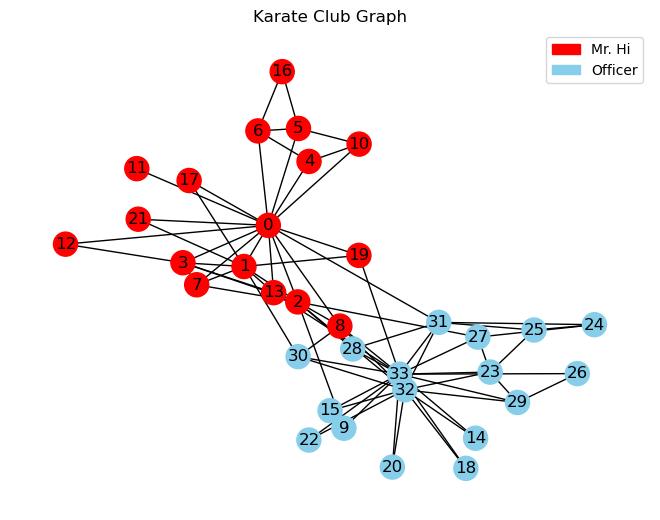

In [3]:
# Generate a node colour for each club in karate club
node_colours = pd.Series(nx.get_node_attributes(G , 'club')).replace('Mr. Hi' , 'r').replace('Officer' , 'skyblue')

# Draw Network
np.random.seed(42) # so we produce the same network each time as the layout is a stochastic algorithm
nx.draw(G , with_labels = True , node_color = node_colours) # draw our network
plt.title('Karate Club Graph')
legend_handles = gen_graph_legend(node_colours , G , 'club') # Generate legend labels from function above
plt.legend(handles = legend_handles)
plt.show()

## <font color='darkblue'>Message Passing Features </font>
We need to specify node features which each node will pass on. In this simple use case we are going to embed the answer in the node feature. We will one-hot encode each club. e.g. Mr Hi's club will be [0,1] and Officer club will be [1,0]. We will mask the participation of some members club by encoding them as [0.5 , 0.5], making it equally likely they belong to each club.

Can we re-identify these members clubs by performing simple message passing over the network?

Node: 0 Feature: [0.5 0.5]
Node: 1 Feature: [0 1]
Node: 2 Feature: [0 1]
Node: 3 Feature: [0 1]
Node: 4 Feature: [0 1]
Node: 5 Feature: [0 1]
Node: 6 Feature: [0.5 0.5]
Node: 7 Feature: [0.5 0.5]
Node: 8 Feature: [0.5 0.5]
Node: 9 Feature: [1 0]
Node: 10 Feature: [0.5 0.5]
Node: 11 Feature: [0 1]
Node: 12 Feature: [0 1]
Node: 13 Feature: [0 1]
Node: 14 Feature: [1 0]
Node: 15 Feature: [1 0]
Node: 16 Feature: [0.5 0.5]
Node: 17 Feature: [0 1]
Node: 18 Feature: [1 0]
Node: 19 Feature: [0 1]
Node: 20 Feature: [1 0]
Node: 21 Feature: [0 1]
Node: 22 Feature: [1 0]
Node: 23 Feature: [0.5 0.5]
Node: 24 Feature: [0.5 0.5]
Node: 25 Feature: [1 0]
Node: 26 Feature: [1 0]
Node: 27 Feature: [1 0]
Node: 28 Feature: [1 0]
Node: 29 Feature: [1 0]
Node: 30 Feature: [1 0]
Node: 31 Feature: [1 0]
Node: 32 Feature: [1 0]
Node: 33 Feature: [1 0]


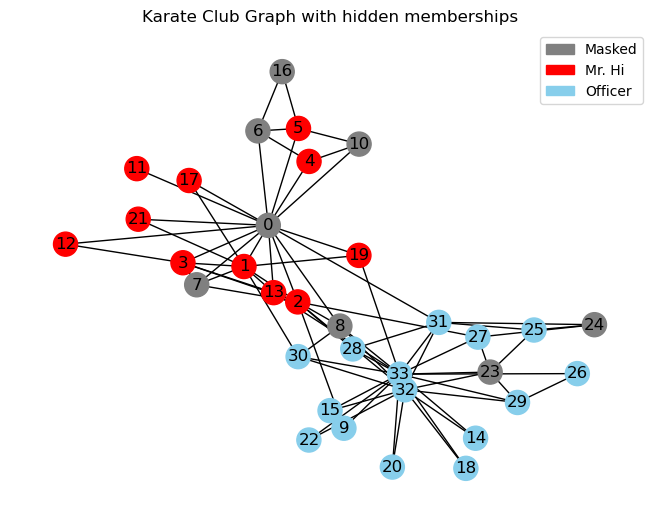

In [4]:
# Add node features to our network

unknown_nodes = np.random.choice(list(G.nodes ) , 10) # randomly select ten nodes for our test set
for node in G.nodes : 
    if node in unknown_nodes : 
        G.nodes[node]['feature'] = np.array([0.5,0.5]) # mask node features as 50/50 chance of being Mr. Hi or Mr. Officer
        G.nodes[node]['club'] = 'Masked'
    else : 
        if G.nodes[node]['club'] == 'Mr. Hi' :
            G.nodes[node]['feature'] = np.array([0 , 1]) # Embed Mr. Hi as [0,1]
        elif G.nodes[node]['club'] == 'Officer' : 
            G.nodes[node]['feature'] = np.array([1 , 0]) # Embed Mr. Officer as [1,0]
        else : 
            print('No club or group found for node')
            
# Access updated node features after one iteration
for node in G.nodes:
    print("Node:", node, "Feature:", G.nodes[node]['feature'])
    
# Draw our updated network
node_colours = pd.DataFrame(nx.get_node_attributes(G , 'feature')).T[0].astype('str').replace('0.0' , 'r').replace('0.5' , 'grey').replace('1.0' , 'skyblue')

np.random.seed(42)
nx.draw(G , with_labels = True , node_color = node_colours) # draw our network
plt.title('Karate Club Graph with hidden memberships') 
legend_handles = gen_graph_legend(node_colours , G , 'club') # Generate legend labels from function above
plt.legend(handles = legend_handles)
plt.show()

## <font color='darkblue'>Message Passing Function </font>
As defined, message passing consists of three main steps. Message propagation, aggregation and update. 

- We need each node to pass or propogate their features to their neighbours. 
- Each node then aggregates these messages using median aggregation
- Each node updates their node features with the aggregate message

Can you define two functions, the first message passing propogates and aggregates node messages and a second function which then updates the node features

In [ ]:
# Define message passing function
def message_passing(node, G):
    """
    Perform message passing for a given node in a graph.

    Parameters:
    node (int): The node for which message passing is performed.
    G (networkx.Graph): The graph containing the node and its neighbors.

    Returns:
    numpy.ndarray: The aggregated message from the neighboring nodes.

    Notes:
    - This function gathers the messages for a single node and will be used in the message_passing_iteration.
    - The function performs propagation and aggregation.
    - Propagation: Gather the node features of all neighboring nodes.
    - Aggregation: Aggregate the gathered messages using median aggregation.
    """
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return G.nodes[node]['feature']
    else:
        '''
        #################################################
                       YOUR CODE HERE
        #################################################
        
        Note. This function gathers the messages for a single node and will be useed
        to iterate over in the message_passing_iteration
        
        In this function you will need to : 
            1. Create a nested list of the node features of neighbouring nodes hint : 
            use list comprehension & G.nodes[neighbor]['feature'] to extract the feature
            2. Aggregate these messages for each node using np.median() or likewise
        '''
        neighbor_features = [G.nodes[neighbor]['feature'] for neighbor in neighbors]
        aggregated_message = np.median(neighbor_features, axis=0)
        
        return aggregated_message


# Perform message passing iteration
def message_passing_iteration(G):
    """
    Perform message passing iteration on a graph.

    Parameters:
    - G (networkx.Graph): The input graph.

    Returns:
    - None

    Description:
    This function performs message passing iteration on a graph.
      It iterates through all nodes in the graph and updates their
      features based on the aggregated message from neighboring nodes.

    Note:
    - The function `message_passing` is defined above.

    """
    
    updated_features = {}
    
    '''
    #################################################
                   YOUR CODE HERE
    #################################################
    
    We will now update our node features with the updated features dictionary
    
    In this function you will need to : 
        1. Iterate through all nodes
        2. create a dictionary where each node is a key and the aggregated message is the value
        3. Iterate through the dictionary created above. hint use updated_features.items()
        4. Update each nodes features
    '''
    for node in G.nodes:
        updated_features[node] = message_passing(node, G)
    
    for node, feature in updated_features.items():
        G.nodes[node]['feature'] = feature

Node: 0 Feature: [0. 1.]
Node: 1 Feature: [0. 1.]
Node: 2 Feature: [0.5 0.5]
Node: 3 Feature: [0. 1.]
Node: 4 Feature: [0.5 0.5]
Node: 5 Feature: [0.5 0.5]
Node: 6 Feature: [0.25 0.75]
Node: 7 Feature: [0. 1.]
Node: 8 Feature: [1. 0.]
Node: 9 Feature: [0.5 0.5]
Node: 10 Feature: [0. 1.]
Node: 11 Feature: [0.5 0.5]
Node: 12 Feature: [0.25 0.75]
Node: 13 Feature: [0. 1.]
Node: 14 Feature: [1. 0.]
Node: 15 Feature: [1. 0.]
Node: 16 Feature: [0.25 0.75]
Node: 17 Feature: [0.25 0.75]
Node: 18 Feature: [1. 0.]
Node: 19 Feature: [0.5 0.5]
Node: 20 Feature: [1. 0.]
Node: 21 Feature: [0.25 0.75]
Node: 22 Feature: [1. 0.]
Node: 23 Feature: [1. 0.]
Node: 24 Feature: [1. 0.]
Node: 25 Feature: [0.5 0.5]
Node: 26 Feature: [1. 0.]
Node: 27 Feature: [0.5 0.5]
Node: 28 Feature: [1. 0.]
Node: 29 Feature: [1. 0.]
Node: 30 Feature: [0.75 0.25]
Node: 31 Feature: [1. 0.]
Node: 32 Feature: [1. 0.]
Node: 33 Feature: [1. 0.]


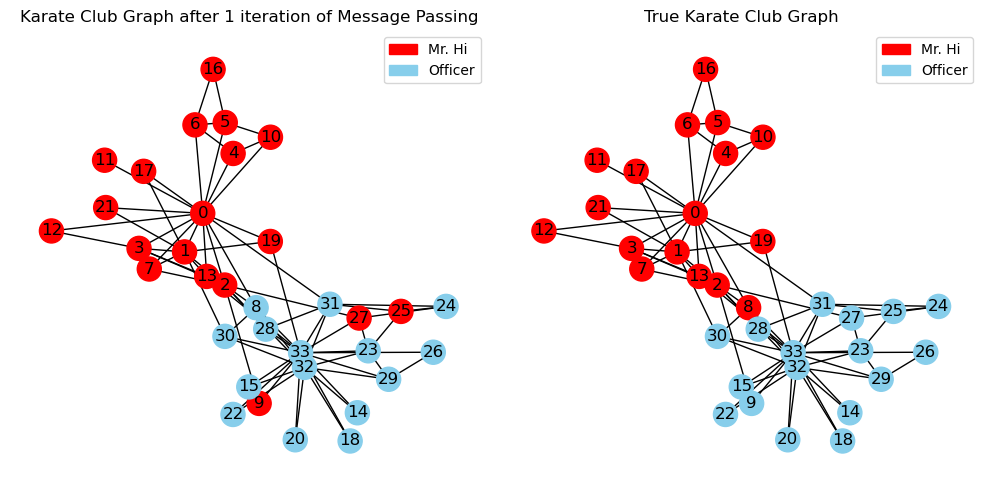

In [36]:
# Example of one iteration of message passing
message_passing_iteration(G)

# Access updated node features after one iteration
for node in G.nodes:
    print("Node:", node, "Feature:", G.nodes[node]['feature'])
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

node_colours_message = (pd.DataFrame(nx.get_node_attributes(G , 'feature')).T[0] > 0.5).replace(True , 'skyblue').replace(False , 'r') # Assign node colours based on node features
np.random.seed(42)
nx.draw(G , ax=axes[0] , with_labels = True , node_color = node_colours_message) # draw our network
axes[0].set_title('Karate Club Graph after 1 iteration of Message Passing')

G_true = nx.karate_club_graph() # Get back original karate club graph
node_colours_true = pd.Series(nx.get_node_attributes(G_true , 'club')).replace('Mr. Hi' , 'r').replace('Officer' , 'skyblue') # Assign node colours based on true club membership
# Draw Network
np.random.seed(42)
nx.draw(G_true , ax=axes[1] , with_labels = True , node_color = node_colours_true) # draw our network
axes[1].set_title('True Karate Club Graph')
legend_handles = gen_graph_legend(node_colours_true , G_true , 'club') # Generate legend labels 
axes[0].legend(handles = legend_handles)
axes[1].legend(handles = legend_handles)

# Adjust layout
plt.tight_layout()
plt.show()

Node: 0 Feature: [0.25 0.75]
Node: 1 Feature: [0.25 0.75]
Node: 2 Feature: [0.5 0.5]
Node: 3 Feature: [0.25 0.75]
Node: 4 Feature: [0.23706055 0.76293945]
Node: 5 Feature: [0.23706055 0.76293945]
Node: 6 Feature: [0.23706055 0.76293945]
Node: 7 Feature: [0.25 0.75]
Node: 8 Feature: [1.00000000e+00 1.97215226e-31]
Node: 9 Feature: [0.75 0.25]
Node: 10 Feature: [0.23706055 0.76293945]
Node: 11 Feature: [0.25 0.75]
Node: 12 Feature: [0.25 0.75]
Node: 13 Feature: [0.25 0.75]
Node: 14 Feature: [1. 0.]
Node: 15 Feature: [1. 0.]
Node: 16 Feature: [0.23706055 0.76293945]
Node: 17 Feature: [0.25 0.75]
Node: 18 Feature: [1. 0.]
Node: 19 Feature: [0.25 0.75]
Node: 20 Feature: [1. 0.]
Node: 21 Feature: [0.25 0.75]
Node: 22 Feature: [1. 0.]
Node: 23 Feature: [1. 0.]
Node: 24 Feature: [1. 0.]
Node: 25 Feature: [1. 0.]
Node: 26 Feature: [1. 0.]
Node: 27 Feature: [1. 0.]
Node: 28 Feature: [1. 0.]
Node: 29 Feature: [1. 0.]
Node: 30 Feature: [1. 0.]
Node: 31 Feature: [1. 0.]
Node: 32 Feature: [1. 0.]
No

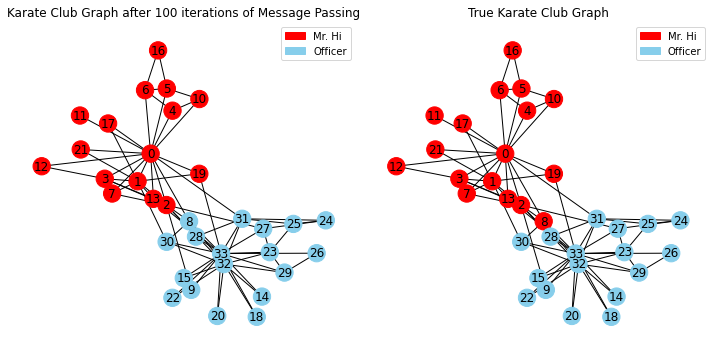

In [9]:
# Example of 100 iterations of message passing
for _ in range(100) : 
    message_passing_iteration(G)
    
# Access updated node features after one iteration
for node in G.nodes:
    print("Node:", node, "Feature:", G.nodes[node]['feature'])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

node_colours_message = (pd.DataFrame(nx.get_node_attributes(G , 'feature')).T[0] > 0.5).replace(True , 'skyblue').replace(False , 'r') # Assign node colours based on node features
np.random.seed(42)
nx.draw(G , ax=axes[0] , with_labels = True , node_color = node_colours_message) # draw our network
axes[0].set_title('Karate Club Graph after 100 iterations of Message Passing')

G_true = nx.karate_club_graph() # Get back original karate club graph
node_colours_true = pd.Series(nx.get_node_attributes(G_true , 'club')).replace('Mr. Hi' , 'r').replace('Officer' , 'skyblue') # Assign node colours based on true club membership
# Draw Network
np.random.seed(42)
nx.draw(G_true , ax=axes[1] , with_labels = True , node_color = node_colours_true)  # draw our network
axes[1].set_title('True Karate Club Graph')
legend_handles = gen_graph_legend(node_colours_true , G_true , 'club') # Generate legend labels
axes[0].legend(handles = legend_handles)
axes[1].legend(handles = legend_handles)

# Adjust layout
plt.tight_layout()
plt.show()

Above we can see that we are able to reclaim the karate club assignments by sharing each nodes belief about their own club. 

Although we mislabel node 8, in general, the message passing algorithm is a very efficient method to update beliefs about unknown node labels. 

In practice, in a supervised learning setting, we will not be giving the node label as the node feature. Instead, we hope that our node feature will be an accurate representation of that nodes label. For example, our node features could be an altered gene expression in a patient with cancer. In this example, for an informative cancer network we can see envision how we will be better able to identify new cancer patients if the messages they receive are from other similar cancer patients, but more on this later.

The main difference between Graph Neural Network architectures is how they perform message passing and how they aggregate messages. Previously, we looked at a median aggregation, next we want to repeat the above using mean aggregation

## <font color='darkblue'>Mean Aggregation </font>

What happens if we change the aggregation function from median to sum or mean. For sum we can easily envision how our current features would explode greater that the 0.5 threshold for all nodes but what about mean? 

First, we will alter our node features which encodes the Officer club as [-1,0]. Introducing the -1 in hope to control the behaviour of the message passing and reaching an equillibrium with mean aggregation.

Node: 0 Feature: [0 0]
Node: 1 Feature: [0 1]
Node: 2 Feature: [0 1]
Node: 3 Feature: [0 1]
Node: 4 Feature: [0 1]
Node: 5 Feature: [0 1]
Node: 6 Feature: [0 0]
Node: 7 Feature: [0 0]
Node: 8 Feature: [0 0]
Node: 9 Feature: [-1  0]
Node: 10 Feature: [0 0]
Node: 11 Feature: [0 1]
Node: 12 Feature: [0 1]
Node: 13 Feature: [0 1]
Node: 14 Feature: [-1  0]
Node: 15 Feature: [-1  0]
Node: 16 Feature: [0 0]
Node: 17 Feature: [0 1]
Node: 18 Feature: [-1  0]
Node: 19 Feature: [0 1]
Node: 20 Feature: [-1  0]
Node: 21 Feature: [0 1]
Node: 22 Feature: [-1  0]
Node: 23 Feature: [0 0]
Node: 24 Feature: [0 0]
Node: 25 Feature: [-1  0]
Node: 26 Feature: [-1  0]
Node: 27 Feature: [-1  0]
Node: 28 Feature: [-1  0]
Node: 29 Feature: [-1  0]
Node: 30 Feature: [-1  0]
Node: 31 Feature: [-1  0]
Node: 32 Feature: [-1  0]
Node: 33 Feature: [-1  0]


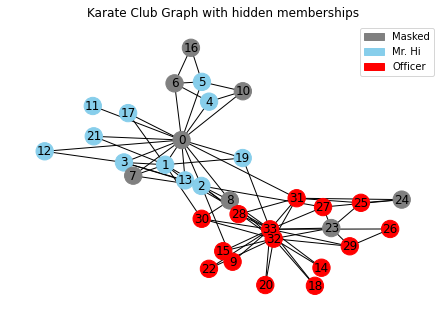

In [8]:
unknown_nodes = np.random.choice(list(G.nodes ) , 10) # randomly select ten nodes for our test set
for node in G.nodes : 
    if node in unknown_nodes : 
        G.nodes[node]['feature'] = np.array([0,0]) # mask node features as 50/50 chance of being Mr. Hi or Mr. Officer
        G.nodes[node]['club'] = 'Masked'
    else : 
        if G.nodes[node]['club'] == 'Mr. Hi' :
            G.nodes[node]['feature'] = np.array([0 , 1]) # Embed Mr. Hi as [0,1]
        elif G.nodes[node]['club'] == 'Officer' : 
            G.nodes[node]['feature'] = np.array([-1 , 0]) # Embed Mr. Officer as [-1,0]
        else : 
            print('No club or group found for node')
            
# Access updated node features after one iteration
for node in G.nodes:
    print("Node:", node, "Feature:", G.nodes[node]['feature'])
    
# Draw our updated network
node_colours = pd.DataFrame(nx.get_node_attributes(G , 'feature')).mean().astype('str').replace('-0.5' , 'r').replace('0.0' , 'grey').replace('0.5' , 'skyblue') # Assign node colours based on node features

np.random.seed(42)
nx.draw(G , with_labels = True , node_color = node_colours)     # draw our network
plt.title('Karate Club Graph with hidden memberships')
legend_handles = gen_graph_legend(node_colours , G , 'club')    # Generate legend labels
plt.legend(handles = legend_handles)
plt.show()

In [9]:
# Define message passing function
def message_passing(node, G):
    """
    Perform message passing on a node in a graph.

    Parameters:
    node (any): The node to perform message passing on.
    G (networkx.Graph): The graph containing the node and its neighbors.

    Returns:
    any: The aggregated message from the node's neighbors.
    """

    neighbors = list(G.neighbors(node))
    if not neighbors:
        return G.nodes[node]['feature']
    else:
        '''
        #################################################
                       YOUR CODE HERE
        #################################################
        
        Re-implement the above code but using np.mean() or likewise instead of median
        '''
        neighbor_features = [G.nodes[neighbor]['feature'] for neighbor in neighbors]
        aggregated_message = np.mean(neighbor_features, axis=0)
        
        return aggregated_message

Node: 0 Feature: [-0.0625  0.6875]
Node: 1 Feature: [-0.11111111  0.66666667]
Node: 2 Feature: [-0.4  0.3]
Node: 3 Feature: [0.         0.66666667]
Node: 4 Feature: [0. 0.]
Node: 5 Feature: [0. 0.]
Node: 6 Feature: [0.  0.5]
Node: 7 Feature: [0.   0.75]
Node: 8 Feature: [-0.6  0.2]
Node: 9 Feature: [-0.5  0.5]
Node: 10 Feature: [0.         0.66666667]
Node: 11 Feature: [0. 0.]
Node: 12 Feature: [0.  0.5]
Node: 13 Feature: [-0.2  0.6]
Node: 14 Feature: [-1.  0.]
Node: 15 Feature: [-1.  0.]
Node: 16 Feature: [0.  0.5]
Node: 17 Feature: [0.  0.5]
Node: 18 Feature: [-1.  0.]
Node: 19 Feature: [-0.33333333  0.33333333]
Node: 20 Feature: [-1.  0.]
Node: 21 Feature: [0.  0.5]
Node: 22 Feature: [-1.  0.]
Node: 23 Feature: [-1.  0.]
Node: 24 Feature: [-1.  0.]
Node: 25 Feature: [-0.33333333  0.        ]
Node: 26 Feature: [-1.  0.]
Node: 27 Feature: [-0.25  0.25]
Node: 28 Feature: [-0.66666667  0.33333333]
Node: 29 Feature: [-0.75  0.  ]
Node: 30 Feature: [-0.5   0.25]
Node: 31 Feature: [-0.6666

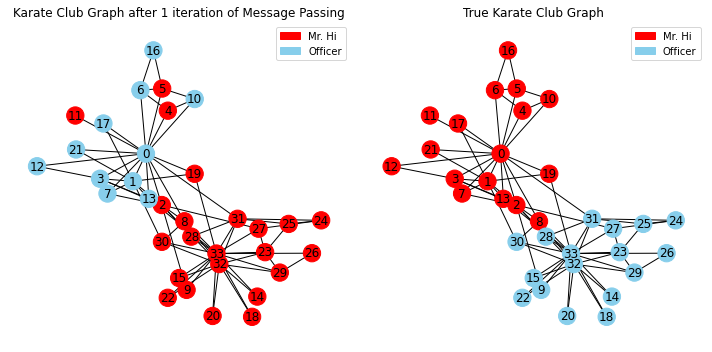

In [10]:
# Example of one iteration of message passing
message_passing_iteration(G)

# Access updated node features after one iteration
for node in G.nodes:
    print("Node:", node, "Feature:", G.nodes[node]['feature'])
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

node_colours_message = (pd.DataFrame(nx.get_node_attributes(G , 'feature')).mean() > 0).replace(True , 'skyblue').replace(False , 'r') # Assign node colours based on node features
np.random.seed(42)
nx.draw(G , ax=axes[0] , with_labels = True , node_color = node_colours_message) # draw our network
axes[0].set_title('Karate Club Graph after 1 iteration of Message Passing')

G_true = nx.karate_club_graph() # Get back original karate club graph
node_colours_true = pd.Series(nx.get_node_attributes(G_true , 'club')).replace('Mr. Hi' , 'r').replace('Officer' , 'skyblue') # Assign node colours based on true club membership
# Draw Network
np.random.seed(42)
nx.draw(G_true , ax=axes[1] , with_labels = True , node_color = node_colours_true) # draw our network
axes[1].set_title('True Karate Club Graph')
legend_handles = gen_graph_legend(node_colours_true , G_true , 'club') # Generate legend labels
axes[0].legend(handles = legend_handles)
axes[1].legend(handles = legend_handles)

# Adjust layout
plt.tight_layout()
plt.show()

Node: 0 Feature: [-0.42948698  0.30128216]
Node: 1 Feature: [-0.42948708  0.30128211]
Node: 2 Feature: [-0.42948719  0.30128205]
Node: 3 Feature: [-0.42948705  0.30128212]
Node: 4 Feature: [-0.42948676  0.30128227]
Node: 5 Feature: [-0.42948671  0.3012823 ]
Node: 6 Feature: [-0.42948671  0.3012823 ]
Node: 7 Feature: [-0.42948706  0.30128212]
Node: 8 Feature: [-0.42948724  0.30128202]
Node: 9 Feature: [-0.42948729  0.301282  ]
Node: 10 Feature: [-0.42948676  0.30128227]
Node: 11 Feature: [-0.42948695  0.30128217]
Node: 12 Feature: [-0.42948699  0.30128215]
Node: 13 Feature: [-0.42948712  0.30128208]
Node: 14 Feature: [-0.42948739  0.30128194]
Node: 15 Feature: [-0.42948739  0.30128194]
Node: 16 Feature: [-0.42948664  0.30128234]
Node: 17 Feature: [-0.42948701  0.30128214]
Node: 18 Feature: [-0.42948739  0.30128194]
Node: 19 Feature: [-0.42948713  0.30128208]
Node: 20 Feature: [-0.42948739  0.30128194]
Node: 21 Feature: [-0.42948701  0.30128214]
Node: 22 Feature: [-0.42948739  0.30128194

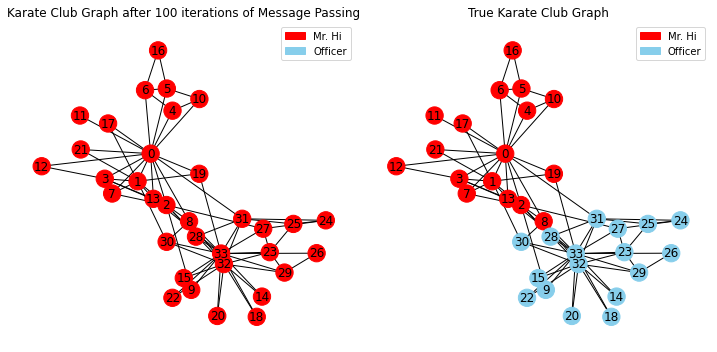

In [11]:
# Example of 100 iterations of message passing
for _ in range(100) : 
    message_passing_iteration(G)
    
# Access updated node features after one iteration
for node in G.nodes:
    print("Node:", node, "Feature:", G.nodes[node]['feature'])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

node_colours_message = (pd.DataFrame(nx.get_node_attributes(G , 'feature')).mean() > 0).replace(True , 'skyblue').replace(False , 'r') # Assign node colours based on node features
np.random.seed(42)
nx.draw(G , ax=axes[0] , with_labels = True , node_color = node_colours_message) # draw our network
axes[0].set_title('Karate Club Graph after 100 iterations of Message Passing')

G_true = nx.karate_club_graph() # Get back original karate club graph
node_colours_true = pd.Series(nx.get_node_attributes(G_true , 'club')).replace('Mr. Hi' , 'r').replace('Officer' , 'skyblue') # Assign node colours based on true club membership
# Draw Network
np.random.seed(42)
nx.draw(G_true , ax=axes[1] , with_labels = True , node_color = node_colours_true) # draw our network
axes[1].set_title('True Karate Club Graph')
legend_handles = gen_graph_legend(node_colours_true , G_true , 'club') # Generate legend labels
axes[0].legend(handles = legend_handles)
axes[1].legend(handles = legend_handles)

# Adjust layout
plt.tight_layout()
plt.show()

## <font color='darkblue'>Message Passing Key Takeaways </font>

1. Message passing is fast. 
2. Message passing is not perfect
        
Can we introduce a non-linearity that allows us to mean and sum aggregate our nodes to prevent feature saturation and learn node labels from features?? -> GNN's!